In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#Métricas para os modelos
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

#Acurracia balanceada entre todas as classes
from sklearn.metrics import balanced_accuracy_score

## Evaluate metrics

In [2]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def specificity_m(y_true, y_pred):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

def balanced_acc(y_true, y_pred):
    ba = (recall(y_true, y_pred) + specificity_m(y_true, y_pred)) * 0.5  
    
    return ba

#Define the name for balanced_accuracy in the fit
balanced_acc.__name__ = 'ba'

### Reading the data

In [3]:
data = np.load('multi_chanel_imagens.npy')

In [4]:
all_games = pd.read_csv('all_games_other_games.csv')
#Geting the target values
y = all_games[all_games['interval_frame_size'] >= 500].target

#Selecting only BPI with 500 or more frames (15 seg)
partidas = pd.DataFrame(all_games[all_games['interval_frame_size'] >= 500].partida)

#Reseting the index of dataframe (to follow the original data)
partidas.reset_index(inplace=True)
partidas.drop(['index'],axis=1, inplace=True)

path_original = ""

In [5]:
game_folds = pd.read_csv(f'{path_original}games_fold_ad.csv',index_col=[0])

In [6]:
games_list_test = []#Lista com o nome das partidas de cada fold
for fold in range(game_folds.columns.size - 1):
    games_names_test = game_folds[(game_folds['turn_'+str(fold)] == 15)].partida.values 
    #Pegando todas as partidas para treinamento
                                                                                    
    games_list_test.append(games_names_test)
    
idx_folds_test = [] #Lista do idx de cada fold do grid search
for fold_idx in range(len(games_list_test)):
    idx_folds_test.append(partidas[partidas.apply(lambda x: x.partida in games_list_test[fold_idx],
                                                          axis=1)].index.values)
    
#Dados de Treino

#Separa os nome de todas as partidas que NAO serão teste nas rodadas
games_list = []#Lista com o nome das partidas de cada fold
for fold in range(game_folds.columns.size - 1):
    games_names = game_folds[(game_folds['turn_'+str(fold)] != 15)].partida.values #Pegando todas as partidas para treinamento
                                                                                    
    games_list.append(games_names)
    
idx_folds = [] #Lista do idx de cada fold do grid search
for fold_idx in range(len(games_list)):
    idx_folds.append(partidas[partidas.apply(lambda x: x.partida in games_list[fold_idx], axis=1)].index.values)  

In [7]:
def get_data(fold):
    '''
    Get the data for training and test for multi channel images (11x167x16)
    '''
    #Selecting the training data
    y_train = y.iloc[idx_folds[fold]].values
    y_train_d = keras.utils.to_categorical(y_train, num_classes = 2)
    X_train = data[idx_folds[fold]]

    #Define the weights of each class
#     weights = get_class_weight(y_train)
#     class_weights = {0:weights[0], 1:weights[1]}

    #Seting the test index od the fold
    X_test = data[idx_folds_test[fold]]
    y_test = y.iloc[idx_folds_test[fold]].values
    y_test_d = keras.utils.to_categorical(y_test, num_classes = 2)
    
    print(f'Leaked data?:{np.unique([index in idx_folds_test[fold] for index in idx_folds[fold]])}')

    return X_train, y_train, y_train_d, X_test, y_test, y_test_d

In [8]:
def load_model(fold):
    
    path_to_load = f'modelos_reviewed/CNN_03/{fold}/CNN_EfficientB0'

    model = keras.models.load_model(path_to_load, custom_objects={'ba':balanced_acc})
        
    return model

### Make the predictions

In [9]:
from tensorflow import keras

In [10]:
from sklearn.metrics import confusion_matrix

In [11]:
ba_accuracys = []
list_confusions_matriz = []

for fold in range(10):
    
    X_train, y_train, y_train_d, X_test, y_test, y_test_d = get_data(fold)
    
    
    model = load_model(fold)
    predict = model.predict(X_test)
    predict_class = [np.argmax(value) for value in predict]
    tn, fp, fn, tp = confusion_matrix(y_test, predict_class).ravel()
    list_confusions_matriz.append([tp, fn, fp, tn])
    
    ba_accuracys.append(balanced_accuracy_score(y_test, predict_class))

Leaked data?:[ True]


Leaked data?:[ True]


Leaked data?:[ True]


Leaked data?:[ True]


Leaked data?:[ True]


Leaked data?:[ True]


Leaked data?:[ True]


Leaked data?:[ True]


Leaked data?:[ True]


Leaked data?:[ True]


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 10, 166, 16)       1040      
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 166, 16)       64        
_________________________________________________________________
conv2 (Conv2D)               (None, 9, 165, 32)        2080      
_________________________________________________________________
reshape (Reshape)            (None, 32, 495, 3)        0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
hidden1 (Dense)              (None, 1280)              1639680   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0

In [13]:
# pd.DataFrame(np.array(ba_accuracys)).to_csv('balanced_acc_gray.csv')
np.array(ba_accuracys)

array([0.5       , 0.5       , 0.54032258, 0.52419355, 0.5       ,
       0.50806452, 0.5       , 0.5       , 0.85887097, 0.5       ])

In [14]:
# tp, fn, fp, tn
list_confusions_matriz

[[0, 4, 0, 62],
 [4, 0, 62, 0],
 [4, 0, 57, 5],
 [4, 0, 59, 3],
 [4, 0, 62, 0],
 [4, 0, 61, 1],
 [4, 0, 62, 0],
 [4, 0, 62, 0],
 [3, 1, 2, 60],
 [4, 0, 62, 0]]

## Creating a random value to static test

In [15]:
import random
random.seed(2020)

In [16]:
list_random_samples = []
for fold in range(10):
    temp_random_samples = []
    X_train, y_train, y_train_d, X_test, y_test, y_test_d = get_data(fold)
    for sample in y_test:
        temp_random_samples.append(random.randrange(0, 2))
        
    list_random_samples.append(balanced_accuracy_score(y_test, temp_random_samples))

Leaked data?:[False]
Leaked data?:[False]
Leaked data?:[False]
Leaked data?:[False]
Leaked data?:[False]
Leaked data?:[False]
Leaked data?:[False]
Leaked data?:[False]
Leaked data?:[False]
Leaked data?:[False]


In [17]:
list_random_samples

[0.4998172514619883,
 0.6251387627409426,
 0.5803477344573236,
 0.5142709257616089,
 0.5093220338983051,
 0.3997160557563242,
 0.5115131578947368,
 0.4652826855123675,
 0.43789073117695027,
 0.6342342342342342]

In [18]:
#save the balanced acc. of the test samples
pd.DataFrame(ba_accuracys).to_csv('efficient_results.csv',index=False)

In [22]:
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from scipy.stats import shapiro

In [24]:
from scipy import stats

((array([-1.49876728, -0.98494667, -0.64703803, -0.37109819, -0.12121409,
          0.12121409,  0.37109819,  0.64703803,  0.98494667,  1.49876728]),
  array([0.39971606, 0.43789073, 0.46528269, 0.49981725, 0.50932203,
         0.51151316, 0.51427093, 0.58034773, 0.62513876, 0.63423423])),
 (0.08132015866332755, 0.5177533572894781, 0.9765722631258008))

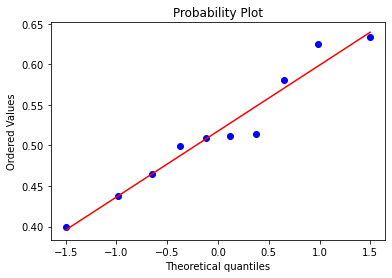

In [26]:
stats.probplot(list_random_samples, dist="norm", plot=plt)

((array([-1.49876728, -0.98494667, -0.64703803, -0.37109819, -0.12121409,
          0.12121409,  0.37109819,  0.64703803,  0.98494667,  1.49876728]),
  array([0.51923077, 0.67839912, 0.74504505, 0.74652778, 0.75066548,
         0.75962898, 0.77681048, 0.79927339, 0.82679401, 0.89501223])),
 (0.09990554710860505, 0.7497387282139987, 0.9238589695594985))

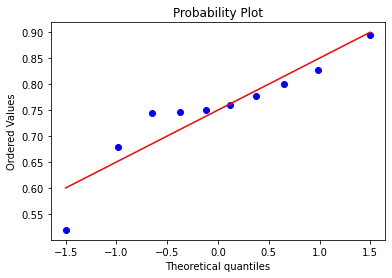

In [25]:
stats.probplot(ba_accuracys, dist="norm", plot=plt)

In [23]:
print(f"Shapiro values for BA {shapiro(ba_accuracys)}")
print(f"Shapiro values for Random Samples {shapiro(list_random_samples)}")

Shapiro values for BA ShapiroResult(statistic=0.8857458829879761, pvalue=0.1517871916294098)
Shapiro values for Random Samples ShapiroResult(statistic=0.9439805746078491, pvalue=0.598093569278717)


In [29]:
#Compair if the 2 samples have idenitical avegare ()
stats.ttest_ind(ba_accuracys, list_random_samples)

Ttest_indResult(statistic=5.858762462840111, pvalue=1.5069625335027887e-05)

In [31]:
#Compare if the expected mean os samples (0.5) is equal to the real mean of values.
#The change is gived by total o correct samples by the total of samples
stats.ttest_1samp(ba_accuracys, 79/1034)

Ttest_1sampResult(statistic=21.46242475651918, pvalue=4.86831983305837e-09)

In [20]:
wilcoxon(ba_accuracys, list_random_samples)

WilcoxonResult(statistic=1.0, pvalue=0.00390625)

In [21]:
wilcoxon(ba_accuracys, list_random_samples)

WilcoxonResult(statistic=1.0, pvalue=0.00390625)